In [149]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio


# POUR LA MORPHO
#from skimage.morphology import watershed
from skimage.feature import peak_local_max



In [150]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory=False #mettre True si vous utilisez google colab
notebook=False   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()

In [151]:
#%% fonction pour voir une image

import tempfile
import numpy as np
import IPython
import matplotlib.pyplot as plt

def viewimage(im, normalize=True,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    if normalize:
        imin-=imin.min()
    if imin.max()>0:
        imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255


    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

In [152]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out

def degrade_image(im,br):
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))

    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]

    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser
# la fonctionnelle E2 par descente de gradient nous avons choisi
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive


def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """

    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I):
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        #print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax):
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))

    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [153]:
#%% lire une image
im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())

# Partie 1 : Débruitage par régularisation quadratique

Q1 : On souhaite minimiser $E_1(f) = \lVert f - v \rVert^2 + \lambda \lVert \nabla f \rVert^2 = \lVert \delta * f - v \rVert^2 + \lVert \sqrt \lambda K_x * f - 0 \rVert^2 + \lVert \sqrt \lambda K_y * f - 0 \rVert^2 = \sum_{i=1}^{3} \|K_i \ast f - v_i\|^2$

Avec $K_1 = \delta$, $K_2 = \sqrt{\lambda} K_x$, $K_3 = \sqrt{\lambda} K_y$, $v_1 = v$ et $v_2 = v_3 = 0$

Pour réaliser cette minimisation, on utilise la fonction resoud_quad_fourier avec les paramètres que l'on vient de donner.

Q2 : Lorsque $\lambda$ est très grand, le terme de régularisation $\lambda \lVert \nabla f \rVert^2$ devient dominant par rapport au terme d'attache aux données $\lVert f - v \rVert^2$. Cela a pour effet de rendre l'image résultante $f$ plus lisse, car la régularité spatiale est fortement privilégiée. En revanche, lorsque $\lambda$ est très petit, l'impact de la régularisation diminue, et l'image résultante $f$ peut conserver plus de détails, mais avec un risque accru de surajustement au bruit.

Q3 :


<ipython-input-152-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-152-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


Nb d iterations : 9


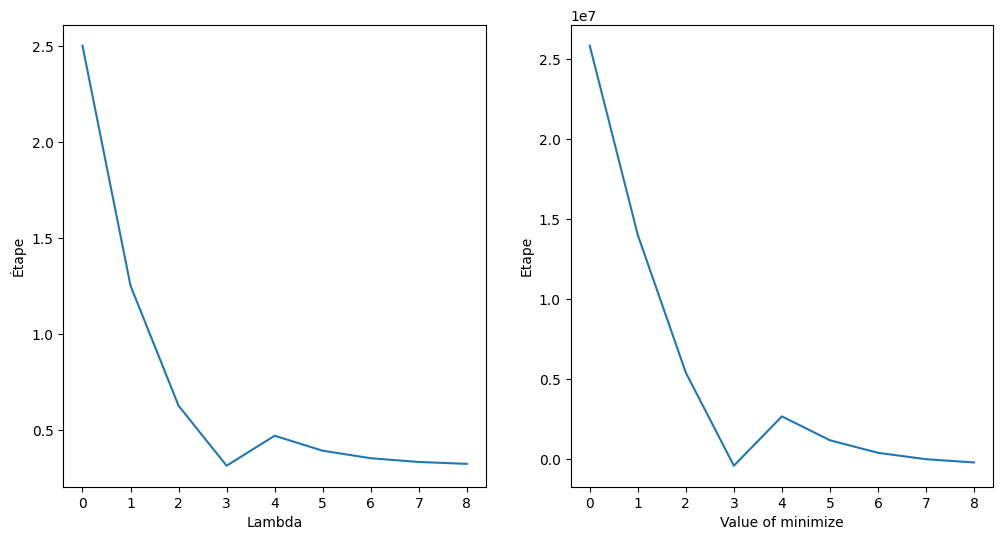

In [154]:
def minimize(u_t, v, lambda_):
  terme1 = np.linalg.norm(u_t - v)**2
  u_min = minimisation_quadratique(v, lambda_)
  terme2 = np.linalg.norm(u_min - v)**2
  return terme2 - terme1

def dichotomie(f, v, lambdas, tolerance=0.01):
  lambda_h = lambdas[1]
  lambda_l = lambdas[0]

  lambdas_ms = []
  min = []

  while lambda_h - lambda_l > tolerance:
    lambda_m = (lambda_h + lambda_l)/2
    mid = minimize(f, v, lambda_m)
    lambdas_ms.append(lambda_m)
    min.append(mid)

    if minimize(f, v, lambda_l) * minimize(f, v, lambda_m) < 0:
        lambda_h = lambda_m
    else:
        lambda_l = lambda_m

  return lambdas_ms, min, len(lambdas_ms), lambdas_ms[-1]

lena = imread('lena.tif')
sigma = 5
v = degrade_image(lena, sigma)

lambdas = [0, 5]
lambdas_ms, mins, nb_iteration, lambd = dichotomie(lena, v, lambdas)
print('Nb d iterations :', nb_iteration)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lambdas_ms)
plt.xlabel('Lambda')
plt.ylabel('Étape')

plt.subplot(1,2,2)
plt.plot(mins)
plt.xlabel('Value of minimize')
plt.ylabel('Etape')

plt.show()

Q4 :

0.322265625


<ipython-input-152-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-152-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


[6541505.932896514, 6372377.48116978, 6214836.2885406995, 6068066.495098841, 5931326.027835457, 5803938.363571754, 5685285.383784251, 5574801.154521877, 5471966.493315725, 5376304.2082202975, 5287374.913030582, 5204773.338177201, 5128125.069497284, 5057083.657553546, 4991328.048852182, 4930560.297529829, 4874503.522108681, 4822900.076973295, 4775509.912474013, 4732109.101151367, 4692488.510615578, 4656452.606198239, 4623818.36869459, 4594414.314396332, 4568079.606228187, 4544663.246187599, 4524023.3404822275, 4506026.429792278, 4490546.8779791305, 4477466.313338382, 4466673.117171111, 4458061.955036986, 4451533.346567656, 4446993.2701708125, 4444352.799351031, 4443527.767722254, 4444438.460093664, 4447009.327281846, 4451168.722541765, 4456848.657721484, 4463984.577434125, 4472515.149707909, 4482382.071724413, 4493529.8893881915, 4505905.829589579, 4519459.644128897, 4534143.464365288, 4549911.665738903, 4566720.74139172, 4584529.184181245, 4603297.376443535, 4622987.486917822, 4643563.

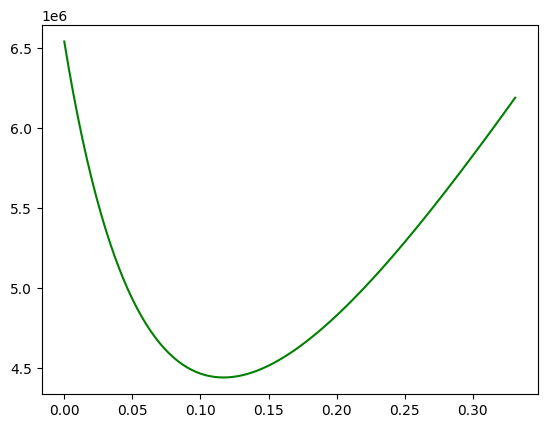

Lambda minimisateur :  0.11707460037385574


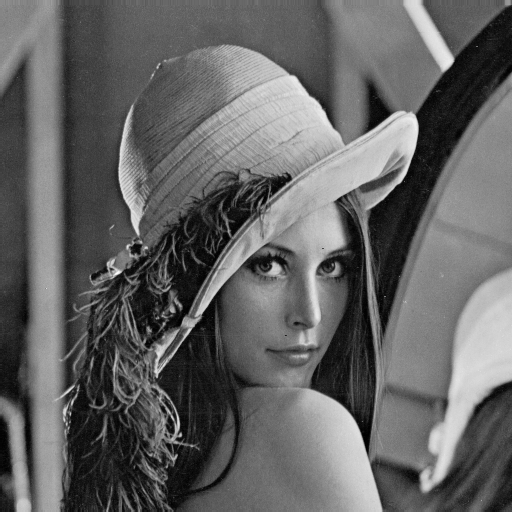

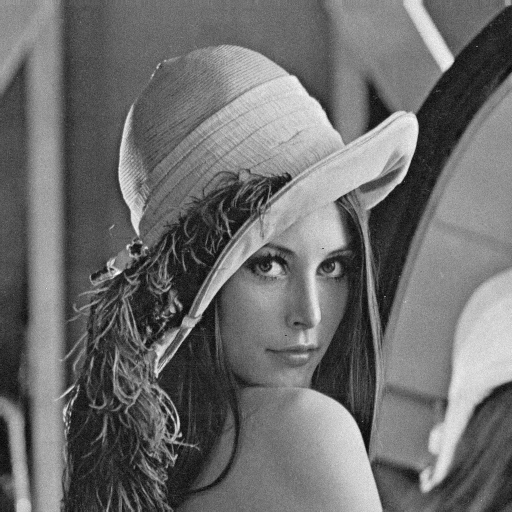

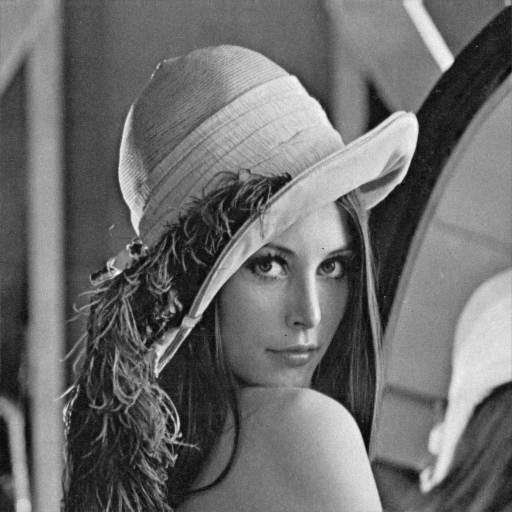

In [155]:
u = lena
sigma = 5
v = degrade_image(u, sigma)
print(lambd)

def func(u, v, lambda_):
  return np.linalg.norm(u - minimisation_quadratique(v, lambda_))**2

lambdas = np.linspace(0,lamb_optimal,100)
f_list = [func(u, v, lambdas[i]) for i in range(len(lambdas))]
print(f_list)

plt.plot(lambdas, f_list, label='Distance au carré entre u et u tilde', color='g')
plt.show()

i_min = np.argmin(f_list)
min = lambdas[i_min]

print('Lambda minimisateur : ', min)

viewimage(u, titre="Image originale")
viewimage(v, titre="Image degradée")
viewimage(minimisation_quadratique(v, min), titre="Minimisation")

# Partie 2 : Débruitage par variation totale

Q1 :

In [156]:
lambda_ = min
pas_list = np.linspace(1e-3, 1e-1, 5)

Energ_tab = []
u_tab = []
for i, pas in enumerate(pas_list):
    u, Energ = minimise_TV_gradient(v, lambda_, pas, 500)
    print(Energ.size)
    Energ_tab.append(Energ)
    u_tab.append(u)

for i,pas in enumerate(pas_list):
  print('Pas', pas)
  print('Energie', Energ_tab[i][499])
#print(len(Energ_tab))
#print(len(u_tab))

500
500
500
500
500
Pas 0.001
Energie 449376561.89001703
Pas 0.025750000000000002
Energie 445736.34135187184
Pas 0.0505
Energie 445736.3484944708
Pas 0.07525000000000001
Energie 445736.3535106384
Pas 0.1
Energie 445736.37367790955


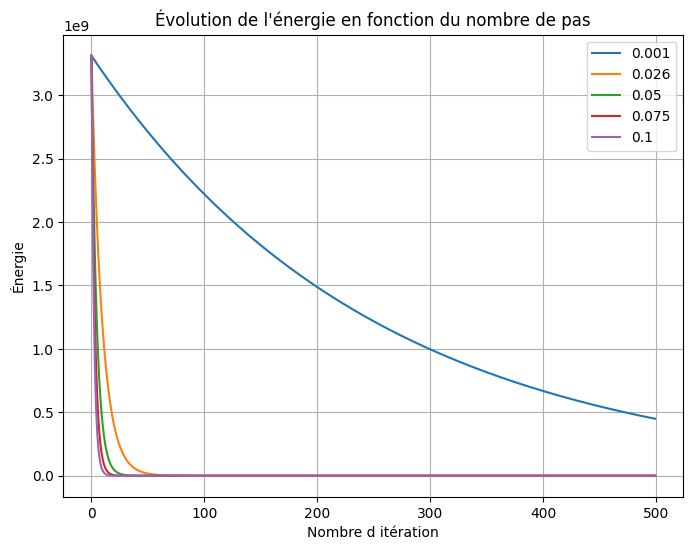

In [157]:
plt.figure(figsize=(8, 6))

for i in range(len(pas_list)):
  plt.plot(Energ_tab[i], linestyle='-', label=round(pas_list[i], 3))

plt.xlabel('Nombre d itération')
plt.ylabel('Énergie')
plt.title('Évolution de l\'énergie en fonction du nombre de pas')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Asymptotiquement, on devrait obtenir une énergie similaire. On remarque que pour des pas supérieurs à 0.001 la convergence est plutôt rapide avec une énergie finale environ égale à 446000. Cependant, pour un pas de 0.001 la convergence est très lente avec une energie finale d'environ 0.5.10^-9

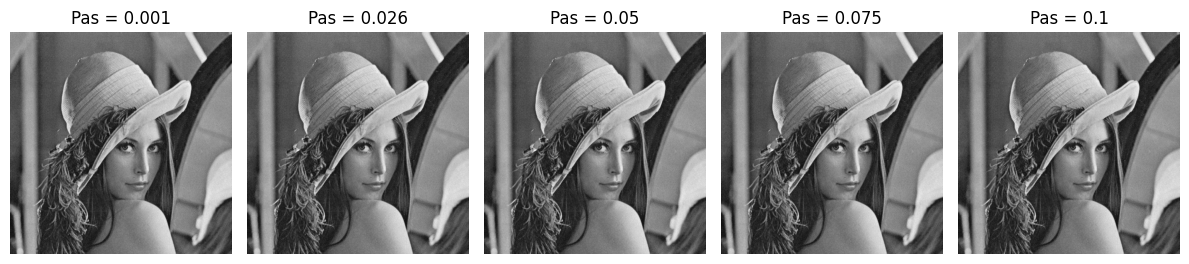

In [158]:
# Affichage des images u obtenues
plt.figure(figsize=(12, 8))
for i, u in enumerate(u_tab):
    plt.subplot(2, 5, i + 1)
    plt.imshow(u, cmap='gray')
    plt.title(f'Pas = {round(pas_list[i], 3)}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Q2 :

Temps d'exécution de vartotale_Chambolle : 4.808552503585815 secondes
Temps d'exécution de minimise_TV_gradient : 6.605950117111206 secondes


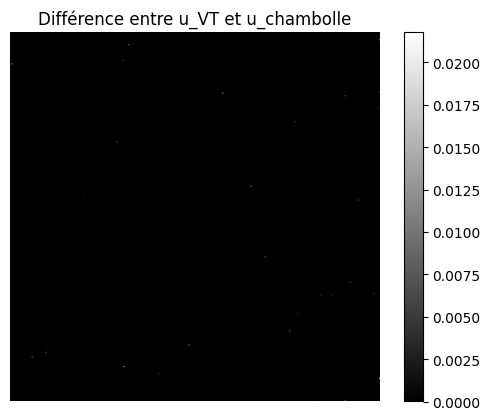

In [159]:
import time

lambda_ = min
pas_grad = 0.1

start_time = time.time()
u_chambolle = vartotale_Chambolle(v, lambda_, 500)
chambolle_execution_time = time.time() - start_time

# Mesurez le temps d'exécution de minimise_TV_gradient
start_time = time.time()
u_VT, E = minimise_TV_gradient(v, lambda_, pas_grad, 500)
gradient_execution_time = time.time() - start_time

# Visualisez la différence entre les résultats
diff_image = np.abs(u_VT - u_chambolle)

# Affichez les temps d'exécution
print(f"Temps d'exécution de vartotale_Chambolle : {chambolle_execution_time} secondes")
print(f"Temps d'exécution de minimise_TV_gradient : {gradient_execution_time} secondes")

# Affichez la différence entre les résultats
plt.imshow(diff_image, cmap='gray')
plt.title('Différence entre u_VT et u_chambolle')
plt.colorbar()
plt.axis('off')
plt.show()

Il n'y a quasiment pas de différence entre les deux méthodes lorsqu'on compare les images obtenues. Cependant, une différence importante concerne les temps d'exécution. On constate que la méthode de Chambolle est beaucoup plus rapide.

# Partie 3 : Comparaison

In [160]:
u = lena
sigma = 25
v = degrade_image(u, sigma)

# Pour E1 :

lambdas = np.linspace(0.1,5,200)
f_list = [func(u, v, lambdas[i]) for i in range(len(lambdas))]
i_min = np.argmin(f_list)
min = lambdas[i_min]

print('Lambda minimisateur pour la minimisation quadratique : ', min)

# Pour E2 :

def func2(u, v, lambda_):
  return np.linalg.norm(u - vartotale_Chambolle(v, lambda_))**2

lambdas2 = np.linspace(0.1,200,100)
f_listc = [func2(u, v, lambdas2[i]) for i in range(len(lambdas2))]
i_minc = np.argmin(f_listc)
minc = lambdas2[i_minc]

print('Lambda minimisateur pour la projection de Chambrolle : ', minc)

<ipython-input-152-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-152-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


Lambda minimisateur pour la minimisation quadratique :  1.1587939698492464
Lambda minimisateur pour la projection de Chambrolle :  40.48383838383838


On trouve $\lambda_q = 1.15$ pour la minimsation quadratique et $\lambda_c = 40.5 $ pour la minimisation avec Chambolle

<ipython-input-152-e3058ab021c2>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-152-e3058ab021c2>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


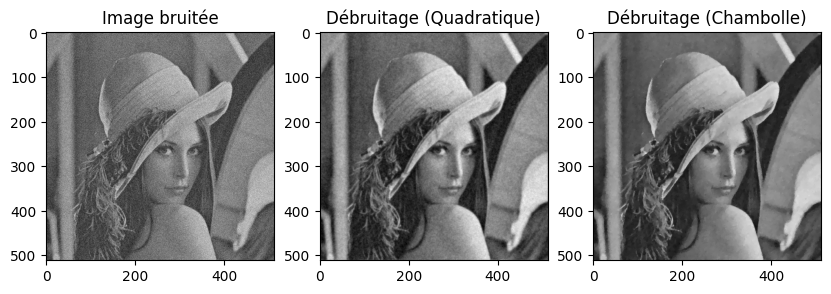

In [163]:
# Débruitage avec la méthode de minimisation quadratique
u_quad = minimisation_quadratique(v, min)

# Débruitage avec la méthode de régularisation TV de Chambolle
u_tv_chambolle = vartotale_Chambolle(v, minc)

# Affichage des images débruitées pour la comparaison
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(v, cmap='gray')
plt.title('Image bruitée')

plt.subplot(1, 3, 2)
plt.imshow(u_quad, cmap='gray')
plt.title('Débruitage (Quadratique)')

plt.subplot(1, 3, 3)
plt.imshow(u_tv_chambolle, cmap='gray')
plt.title('Débruitage (Chambolle)')

plt.show()

La projection de Chambolle offre des résultats plus nets. Cette méthode de débruitage se concentre sur la réduction du bruit tout en préservant les détails de l'image, produisant ainsi des images débruitées plus claires et nettes.